In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen_Aug_Dict import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 42
IMG_SIZE = 380
N_MELS = 224
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 14000
WIN_LENGHT = 1024
BATCH_SIZE = 200
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
bird_classes = [
    "acafly",
    "acowoo",
    "aldfly",
    "ameavo",
    "amecro",
    "amegfi",
    "amekes",
    "amered",
    "amerob",
    "amewig",
    "amtspa",
    "andsol1",
    "annhum",
    "astfly",
    "azaspi1",
    "babwar",
    "balori",
    "banana",
    "banwre1",
    "barant1",
    "barswa",
    "bawswa1",
    "bawwar",
    "baywre1",
    "bbwduc",
    "belkin1",
    "bewwre",
    "bkbwar",
    "bkcchi",
    "bkhgro",
    "bkmtou1",
    "bknsti",
    "blbgra1",
    "blbthr1",
    "blcjay1",
    "blsspa1",
    "blugrb1",
    "blujay",
    "bncfly",
    "bnhcow",
    "bobfly1",
    "brbmot1",
    "brcvir1",
    "brebla",
    "brncre",
    "brnjay",
    "brnthr",
    "brratt1",
    "brwhaw",
    "brwpar1",
    "btbwar",
    "btnwar",
    "btywar",
    "bucmot2",
    "buggna",
    "bugtan",
    "buhvir",
    "bulori",
    "burwar1",
    "bushti",
    "calqua",
    "caltow",
    "cangoo",
    "canwar",
    "carchi",
    "carwre",
    "casfin",
    "caster1",
    "casvir",
    "ccbfin",
    "cedwax",
    "chbant1",
    "chbchi",
    "chbwre1",
    "chcant2",
    "chispa",
    "chswar",
    "cinfly2",
    "clanut",
    "clcrob",
    "cliswa",
    "cobtan1",
    "colcha1",
    "coltro1",
    "comgra",
    "comloo",
    "commer",
    "compau",
    "compot1",
    "comrav",
    "comyel",
    "cotfly1",
    "cowscj1",
    "crfpar",
    "daejun",
    "dowwoo",
    "ducfly",
    "dusfly",
    "easblu",
    "easkin",
    "easmea",
    "easpho",
    "eastow",
    "eawpew",
    "eucdov",
    "eursta",
    "fepowl",
    "fiespa",
    "flrtan1",
    "foxspa",
    "gartro1",
    "gbbgul",
    "gbwwre1",
    "gcrwar",
    "gnttow",
    "gocfly1",
    "gockin",
    "gocspa",
    "goftyr1",
    "gohque1",
    "goowoo1",
    "grasal1",
    "grbani",
    "grbher3",
    "grcfly",
    "grekis",
    "grethr1",
    "gretin1",
    "greyel",
    "grhcha1",
    "grhowl",
    "grnher",
    "grnjay",
    "grtgra",
    "grycat",
    "gryhaw2",
    "haiwoo",
    "herthr",
    "herwar",
    "higmot1",
    "hofwoo1",
    "houfin",
    "houspa",
    "houwre",
    "hutvir",
    "incdov",
    "indbun",
    "kebtou1",
    "killde",
    "larspa",
    "laufal1",
    "laugul",
    "lazbun",
    "leafly",
    "leasan",
    "lesgol",
    "lesgre1",
    "lesvio1",
    "linspa",
    "linwoo1",
    "littin1",
    "lobgna5",
    "lotduc",
    "lotman1",
    "macwar",
    "magwar",
    "mallar3",
    "marwre",
    "meapar",
    "melbla1",
    "monoro1",
    "mouchi",
    "moudov",
    "mouela1",
    "mouqua",
    "mouwar",
    "naswar",
    "nocall",
    "norcar",
    "norfli",
    "normoc",
    "norpar",
    "norwat",
    "nrwswa",
    "nutwoo",
    "oaktit",
    "obnthr1",
    "ocbfly1",
    "olsfly",
    "orbspa1",
    "orcpar",
    "orcwar",
    "orfpar",
    "osprey",
    "ovenbi1",
    "pabspi1",
    "palwar",
    "pasfly",
    "pibgre",
    "pilwoo",
    "pinsis",
    "pirfly1",
    "plawre1",
    "plsvir",
    "prowar",
    "purfin",
    "purgal2",
    "putfru1",
    "pygnut",
    "rawwre1",
    "rebnut",
    "rebsap",
    "rebwoo",
    "reevir1",
    "rehbar1",
    "relpar",
    "reshaw",
    "rethaw",
    "rewbla",
    "ribgul",
    "rinkin1",
    "roahaw",
    "robgro",
    "royter1",
    "rtlhum",
    "rubpep1",
    "rubwre1",
    "ruckin",
    "rucspa1",
    "rucwar",
    "rucwar1",
    "rudpig",
    "rugdov",
    "rumfly1",
    "runwre1",
    "rutjac1",
    "saffin",
    "sancra",
    "sander",
    "savspa",
    "saypho",
    "scamac1",
    "scatan",
    "scbwre1",
    "scptyr1",
    "scrtan1",
    "semplo",
    "shicow",
    "smbani",
    "sobtyr1",
    "socfly1",
    "solsan",
    "sonspa",
    "soulap1",
    "sposan",
    "spotow",
    "spvear1",
    "stejay",
    "sthant1",
    "sthwoo1",
    "strcuc1",
    "strfly1",
    "strsal1",
    "stvhum2",
    "sumtan",
    "swaspa",
    "swathr",
    "tenwar",
    "thbeup1",
    "thswar1",
    "towsol",
    "treswa",
    "trogna1",
    "trokin",
    "tromoc",
    "tropar",
    "tuftit",
    "veery",
    "vigswa",
    "warvir",
    "wbwwre1",
    "wegspa1",
    "wesant1",
    "wesblu",
    "weskin",
    "wesmea",
    "westan",
    "wewpew",
    "whbman1",
    "whbnut",
    "whcpar",
    "whcspa",
    "whevir",
    "whfpar1",
    "whiwre1",
    "whtdov",
    "whtspa",
    "whwbec1",
    "whwdov",
    "wilfly",
    "wiltur",
    "wlswar",
    "wooduc",
    "woothr",
    "wrenti",
    "y00475",
    "yebcha",
    "yebela1",
    "yebfly",
    "yebori1",
    "yebsap",
    "yebsee1",
    "yefgra1",
    "yehbla",
    "yehcar1",
    "yelwar",
    "yerwar",
    "yeteup1",
    "yetvir",
]

In [4]:
bird_classes.sort()

In [5]:
dict_birds = {}
for i, bird in enumerate(bird_classes):
    dict_birds[bird] = i

In [6]:
# os.mkdir("/app/_data/models/dict_features/Eff2_319cl_dict_1/")

In [7]:
file_json = open(
    "/app/_data/models/dict_features/Eff2_319cl_dict_1/dict_birds.json", "w"
)
json.dump(dict_birds, file_json)
file_json.close()

In [8]:
len(dict_birds)

319

In [9]:
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("primary_label in @bird_classes").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)
all_audio.shape

# dict_birds and weights

all_audio = all_audio[all_audio["rating"] >= 3]

all_audio.shape

dict_birds, all_audio = make_dict_birds(all_audio, secondary=False)

len(dict_birds)

dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

short_audio = all_audio[all_audio["rating"] != 6].reset_index(
    drop=True
)  # only short audio
train_sondscapes = all_audio[all_audio["rating"] == 6].reset_index(
    drop=True
)  # only train_soundscapes
short_audio.shape
train_sondscapes.shape
train_sondscapes["duration"] = 600

## calls

short_audio_0_20 = short_audio[short_audio["duration"] < 19]
short_audio_20_30 = short_audio[
    (short_audio["duration"] >= 19) & (short_audio["duration"] <= 30)
]
short_audio_30 = short_audio[short_audio["duration"] > 30]

short_audio_20_30["duration"] = short_audio_20_30["duration"] - 4
short_audio_30["duration"] = short_audio_30["duration"] - 7

short_audio = pd.concat(
    [short_audio_0_20, short_audio_20_30, short_audio_30], axis=0, ignore_index=True
)

short_audio.shape

# Make intervals for short audio

array_for_cut = short_audio[["filename", "duration", "class_weights"]].values

birds_intervals = make_intervals(array_for_cut, 5, max_intervals=150, max_lenght=300)
birds_intervals = birds_intervals.sample(frac=1, random_state=SEED)
birds_intervals.shape

birds_intervals["row_id"] = birds_intervals.index
birds_intervals["filename"].value_counts()

dict_w = pd.DataFrame((1 / birds_intervals["filename"].value_counts()))
dict_w.columns = ["weights"]
dict_w["filename"] = dict_w.index

birds_intervals = birds_intervals.merge(dict_w, on="filename", how="left")

birds_intervals_sample = birds_intervals.sample(
    n=700000, weights="weights", random_state=SEED
)

birds_intervals_sample = birds_intervals_sample.sample(
    n=500000, weights="class_weights", random_state=SEED
)

birds_intervals_sample[birds_intervals_sample["filename"] == "XC196037.ogg"]

short_audio = birds_intervals_sample.merge(
    short_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)

short_audio["filename"].value_counts()

short_audio["end_sec"] = short_audio["end_sec"].apply(lambda x: x if x > 5 else 5)

short_audio["start_sec"] = short_audio["end_sec"] - 5

short_audio["primary_label"].value_counts()

# train_sondscapes

train_sondscapes[train_sondscapes["primary_label"] != "nocall"]["duration"]

short_audio = pd.concat(
    [short_audio, train_sondscapes], axis=0, ignore_index=True
).sample(frac=1, random_state=SEED)

# nocall

nocall = nocall.drop_duplicates()

nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

nocall = nocall[~nocall["file_path"].str.contains("train_soundscapes")].reset_index(
    drop=True
)

soundscapes_nocall = all_audio[all_audio["file_path"].str.contains("train_soundscapes")]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall["primary_label"] == "nocall"]

dict_w = (1 / nocall["filename"].value_counts()).to_dict()
nocall["weights"] = nocall["filename"].replace(dict_w)

nocall_sample = nocall.sample(1200, random_state=SEED, weights="weights")

nocall_sample["filename"].value_counts()

nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "class_weights",
        ]
    ],
    on="filename",
    how="left",
)

nocall_sample = nocall_sample[
    [
        "filename",
        "row_id",
        "start_sec",
        "end_sec",
        "file_path",
        "duration",
        "rating",
        "year",
        "sin_month",
        "cos_month",
        "sin_longitude",
        "cos_longitude",
        "latitude",
        "norm_latitude",
        "class_weights",
    ]
]
soundscapes_nocall = soundscapes_nocall[
    [
        "filename",
        "row_id",
        "start_sec",
        "end_sec",
        "file_path",
        "duration",
        "rating",
        "year",
        "sin_month",
        "cos_month",
        "sin_longitude",
        "cos_longitude",
        "latitude",
        "norm_latitude",
        "class_weights",
    ]
]

soundscapes_nocall["duration"] = 600

all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

all_nocall["label_id"] = dict_birds["nocall"]
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

all_nocall.isna().sum()
all_nocall = all_nocall.dropna(axis=0)
all_nocall["secondary_labels_id"] = np.nan
all_nocall["year"].describe()

# concat

final_audio = (
    pd.concat(
        [short_audio, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(10)

#  upsampling


rare_birds = list(final_audio["primary_label"].value_counts().tail(10).index.values)

df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
        all_audio.query("primary_label ==@bird")["filename"].unique().tolist()
    )
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array, sum_intervals=600)
    df = pd.concat([df, intervals], axis=0)

df

df["filename"].unique().shape

df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

df["primary_label"].unique().shape

final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

final_audio["secondary_labels_id"] = final_audio["secondary_labels_id"].replace(
    "", np.nan
)

final_audio["secondary_labels_id"].unique()

In [10]:
final_audio.to_csv(
    "/app/_data/models/dict_features/Eff2_319cl_dict_1/final_audio.csv", index=False
)

In [11]:
# final_audio=pd.read_csv('/app/_data/models/dict_features/Eff2_319cl_dict_1/final_audio.csv')

In [12]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [13]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 150

In [14]:
NUM_CLASSES

319

In [15]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=N_MELS,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [18]:
gen_train = MEL_Gen(
    df=train,
    n_mels=N_MELS,
    seed=SEED,
    sin_cos_img=False,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    nocall_label_id=dict_birds["nocall"],
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/mels_224_380_uint8_1d/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=True,
    img_dtype="uint8",
    secondary_coeff=0.3,
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=N_MELS,
    seed=SEED,
    sin_cos_img=False,
    nocall_label_id=dict_birds["nocall"],
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/mels_224_380_uint8_1d/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3,
)

In [19]:
a = gen_train.__getitem__(2)

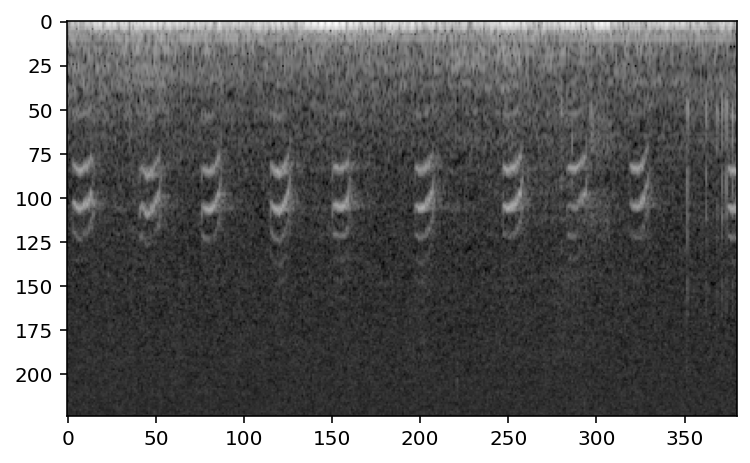

In [23]:
plt.imshow(a[0]["mel"][1])

# model

In [25]:
def get_model():
    input_mel = keras.Input(shape=(N_MELS, IMG_SIZE, 3), name="mel")
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x_mel = base_model(input_mel)
    x_mel = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x_mel)

    input_data = keras.Input(shape=6, name="data")
    x_features = keras.layers.Dense(32, activation="relu", name="dense_data_1")(
        input_data
    )
    x_features = keras.layers.Dense(32, activation="relu", name="dense_data_2")(
        x_features
    )
    x_features = keras.layers.Dense(32, activation="relu", name="dense_data_3")(
        x_features
    )
    x = keras.layers.Concatenate(axis=1, name="all",)(
        [
            x_mel,
            x_features,
        ]
    )
    outputs = keras.layers.Dense(len(dict_birds), activation="sigmoid")(x)
    model = keras.Model(inputs=[input_mel, input_data], outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=30, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/dict_features/Eff2_319cl_dict_1/Eff2_224_380_319_6_1.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_319cl_d2/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/dict_features/Eff2_319cl_dict_1/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [ ]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

31793152/31790344 [==============================] - 2s 0us/step
Epoch 26/100
   1/2727 [..............................] - ETA: 3s - loss: 0.0025 - acc: 0.9733 - recall: 0.5842 - precision: 0.9879 - f1_score: 0.8621WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2727/2727 [==============================] - ETA: 0s - loss: 0.0024 - acc: 0.9896 - recall: 0.5926 - precision: 0.9945 - f1_score: 0.8818
Epoch 00026: val_loss improved from inf to 0.00336, saving model to /app/_data/models/dict_features/Eff2_319cl_dict_1/Eff2_224_380_319_6_1.h5
2727/2727 [==============================] - 3270s 1s/step - loss: 0.0024 - acc: 0.9896 - recall: 0.5926 - precision: 0.9945 - f1_score: 0.8818 - val_loss: 0.0034 - val_acc: 0.9498 - val_recall: 0.5751 - val_precision: 0.9825 -